In [20]:
import os

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pymorphy2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score

from keras.preprocessing import sequence
from keras.regularizers import l2
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import ModelCheckpoint
from keras_tqdm import TQDMNotebookCallback, TQDMCallback

from keras.models import Model
from keras.layers import Dense
from keras.layers import Input, Dropout
from keras.layers import concatenate
from keras.layers import Embedding
from keras.layers import LSTM
from keras.metrics import sparse_categorical_accuracy

from nltk.corpus import stopwords

%matplotlib inline

In [2]:
STOP_WORDS = stopwords.words('russian')
morph = pymorphy2.MorphAnalyzer()

# Считывание и подготовка данных

* Чтение файла
* Округление рейтинга
* Препроцессинг текста: удаление пунктуации, стоп-слов, приведение к нормальной форме

In [3]:
df = pd.read_csv('X_train.csv')
df.rename(columns={'reting': 'rating'}, inplace=True)
df.rating = df.rating.apply(lambda x: round(x))

In [4]:
NUM_CLASSES = len(df.rating.unique())

In [5]:
from string import punctuation

def preprocess(text, drop_punct=True, drop_stop=True, normalize=True):
    text = text.lower()
    
    if drop_punct:
        text = ''.join([c for c in text if c not in punctuation])
    
    if drop_stop:
        text = text.split()
        text = [w for w in text if not w.lower() in STOP_WORDS]
        text = " ".join(text)
    
    if normalize:
        text = text.split()
        text = [morph.parse(w)[0].normal_form for w in text]
        text = " ".join(text)

    return text

In [6]:
df.comment = df.comment.apply(preprocess)
base_df = df.copy()

## Построим распределение длин текстов

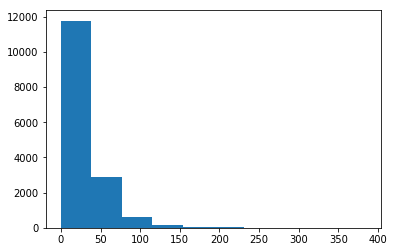

In [7]:
lengths = df.comment.apply(lambda x: len(x.split()))
plt.hist(lengths);

## Подготовка категориальных данных

In [8]:
def convert_to_category(df, feature):
    keys = df[feature].unique()
    values = list(range(len(keys)))
    mapping = dict(zip(keys, values))
    return df[feature].apply(lambda x: mapping[x])

features = ['categoryLevel1Id', 'brandId', 'sku', 'categoryLevel2Id', 'userName']

for feature in features:
    df[feature] = MinMaxScaler().fit_transform(convert_to_category(df, feature).values.reshape(-1, 1))

/root/env/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, _DataConversionWarning)


## Токенизация текстов (преобразование слов в их индексы в словаре)

In [9]:
nb_top_words = None
sentence_length = 150
embedding_dim = 100

texts = df.comment
tokenizer = Tokenizer(num_words=nb_top_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
word_index = tokenizer.word_index

## Паддинг предложений (заполнение нулями до определенной длины)

Оптимальную длину определили по распределению выше

In [10]:
sequences = pad_sequences(sequences, maxlen=sentence_length)

## Перемешивание данных

In [11]:
def shuffle(*arrs):
    a = arrs[0]
    p = np.random.permutation(len(a))
    return list(map(lambda arr: arr[p], arrs))

sequences, df = shuffle(sequences, df.loc)

## Разделение данных на train, validation и test

In [12]:
random_state = 1
val_size = 0.2
test_size = 0.1
df_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state)
seq_train, seq_test = train_test_split(sequences, test_size=test_size, random_state=random_state)

df_train, df_val = train_test_split(df_train, test_size=val_size, random_state=random_state)
seq_train, seq_val = train_test_split(seq_train, test_size=val_size, random_state=random_state)

y_train = df_train.rating.apply(lambda x: x - 1)
y_val = df_val.rating.apply(lambda x: x - 1)
y_test = df_test.rating.apply(lambda x: x - 1)

In [13]:
print('x_train shape: {}, y_train shape: {}'.format(df_train.shape, y_train.shape))
print('x_val shape: {}, y_val shape: {}'.format(df_test.shape, y_test.shape))
print('x_test shape: {}, y_test shape: {}'.format(df_val.shape, y_val.shape))

x_train shape: (11222, 11), y_train shape: (11222,)
x_val shape: (1559, 11), y_val shape: (1559,)
x_test shape: (2806, 11), y_test shape: (2806,)


## Создание модели на Keras

![архитектура](arch.jpg)

In [22]:
def emb_layer(input_length=sentence_length):
    emb = Embedding(len(word_index) + 1,
                    embedding_dim,
                    weights=None,
                    input_length=input_length,
                    trainable=True
                   )    
    return emb

def model_lstm():
    input_texts = Input(shape=(sentence_length,), dtype='float32', name='input_texts')
    input_features = Input(shape=(len(features),), dtype='float32', name='input_features')
    
    emb_text = emb_layer()(input_texts)
    net_text = LSTM(32, return_sequences=True, dropout=0.2)(emb_text)
    net_text = LSTM(16, recurrent_dropout=0.2, activity_regularizer=l2(0.003))(emb_text)
    net_text = Dropout(0.2)(net_text)
    
    net_features = Dense(32, activation='relu', activity_regularizer=l2(0.003))(input_features)
    net_features = Dropout(0.2)(net_features)
    
    net = concatenate([net_text, net_features])
    net = Dense(32)(net)
    
    output = Dense(NUM_CLASSES, activation='sigmoid')(net)

    model = Model(inputs=[input_texts, input_features], outputs=[output])
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

## Обучение модели

Используем сохранение лучшей модели по loss и затем восстановим ее для проведения проверки на test set

In [23]:
model = model_lstm()

models_path = './models'
if not os.path.exists(models_path):
    os.mkdir(models_path)

best_model_path = os.path.join(models_path, 'mvideo.hdf5')

x_train = [seq_train, df_train[features].as_matrix()]
x_val = [seq_val, df_val[features].as_matrix()]

epochs = 4
h = model.fit(x_train, y_train, 
          epochs=epochs, 
          batch_size=64, 
          verbose=1,
          shuffle=True,
          validation_data=(x_val, y_val),
          callbacks=[
              ModelCheckpoint(filepath=best_model_path, monitor='val_loss', verbose=1, save_best_only=True),
          ])

Train on 11222 samples, validate on 2806 samples
Epoch 1/4
11222/11222 [==============================] - 70s - loss: 1.2679 - acc: 0.5950 - val_loss: 1.0843 - val_acc: 0.6012
Epoch 2/4
11222/11222 [==============================] - 72s - loss: 0.9223 - acc: 0.6590 - val_loss: 1.0545 - val_acc: 0.6112
Epoch 3/4
11222/11222 [==============================] - 69s - loss: 0.7612 - acc: 0.7037 - val_loss: 1.1247 - val_acc: 0.5830
Epoch 4/4
11222/11222 [==============================] - 70s - loss: 0.6572 - acc: 0.7106 - val_loss: 1.2773 - val_acc: 0.5520


In [24]:
model.load_weights(best_model_path)

## Графики обучения модели

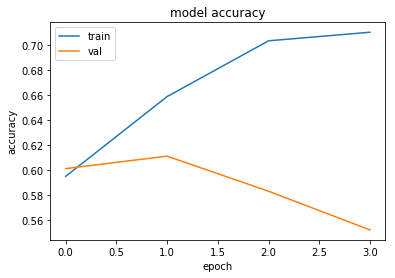

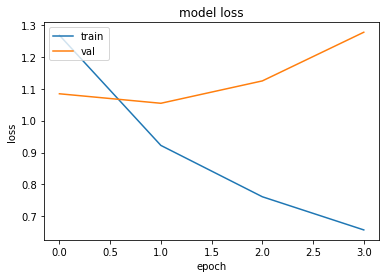

In [25]:
history = h
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Проверка работы модели на test set

In [26]:
x_test = [seq_test, df_test[features].as_matrix()]

y_pred = model.predict(x_test)

In [31]:
y_pred_classes = np.argmax(y_pred, axis=1)
acc = accuracy_score(y_true=y_test, y_pred=y_pred_classes)
print('Test accuracy: {:.3f}'.format(acc))

Test accuracy: 0.623
